## 4.2 Fully Connected Structure--Using Keras Tuner


## run first

In [ ]:
from tensorflow import keras 
from tensorflow import keras as ks
import numpy as np
import pandas as pd
import sklearn as sk
import time
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import optimizers

from keras import backend as K
from keras import regularizers
from keras import initializers
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Preprocess the data into right format

In [ ]:
## unroll the height and width and thickness into one big vector
x_train = X.reshape(1649, 10000)
x_test = X_test.reshape(413, 10000)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

## normalize pixel values from 0 to 255
x_train /= 255
x_test /= 255

y_train = Y
y_test = Y_test

set up learning rate from various Dacay rate

In [ ]:
import tensorflow
## exponential Decay
initial_learning_rate = 0.1
exponential = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Piecewise Constant Decay ===> learning rate nan
step = tensorflow.Variable(0, trainable=False)
boundaries = [100000, 110000]
values = [1.0, 0.5, 0.1]
piecewise = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
# Later, whenever we perform an optimization step, we pass in the step.
# learning_rate = piecewise(step)

# Polynomial Decay ====> best performance
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 10000
polynomial = keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

## try tuner
The best result is 0.55


In [ ]:
# set hyper-parameters
batch_size = 128
num_classes = 10
epochs = 5

The tuner part is to use `keras.tuner` to find out the best number of neruals and what activation function is to use for each layer. Also, this can test how many layer should we get from the nerual network.     
    
I tried to set up the first layer as Dense layer, and set up with the min neural value as 16, the max as 4096, and to step up with 16. The activation choice are `relu`, `sigmoid`, `tanh`, and try to use l1/l2 as kernel_regularizer.      
     
There is a for loop in the middle of the code, which I tried to set up a 2-10 layer for network to find out the best layer number I can have. 

In [ ]:
import math
try: 
  import keras_tuner
except: 
  !pip install keras-tuner --upgrade
finally: 
  import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    # model.add(layers.Flatten())
    # Tune the number of layers.
    # 原来是min = 16, max = 4096, step = 16
    model.add(Dense(units=hp.Int("1", min_value=16, max_value=4096, step=16),
                    activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
                    input_shape = (10000, ), 
                kernel_regularizer = regularizers.l2(0.001), 
                kernel_initializer=initializers.RandomNormal(mean=0, stddev = 1/math.sqrt(28))))
    for i in range(hp.Int("num_layers", 2, 10)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=4096, step=16),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
            )
        )
        #
        # model.add(layers.BatchNormalization())
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))
    #    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_classes, activation="softmax"))
    # normalize output
    # model.add(layers.BatchNormalization())
    learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=polynomial),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

It turns out to have the best model score to be 0.728, with 3 hidden layers, as the first layer has 2976 neruals with activation function is `relu`, the second layer has 528 neurals, and the thrid layer has 1504 neruals. The learning rate is finally to be 0.01978.     
     


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/drive/MyDrive/HUDK_4050_Final/",
    project_name="tuner",
)

search_result = tuner.search(x = x_train, y = y_train, epochs = 40, 
            
             batch_size = 128,
             validation_data = (x_test, y_test))

tuner.results_summary()

Trial 3 Complete [00h 14m 51s]
val_accuracy: 0.3615819215774536

Best val_accuracy So Far: 0.7288135488828024
Total elapsed time: 00h 44m 13s
Results summary
Results in /content/drive/MyDrive/HUDK_4050_Final/tuner
Showing 10 best trials
Trial summary
Hyperparameters:
1: 2976
activation: relu
num_layers: 2
units_0: 528
units_1: 1504
dropout: False
lr: 0.01978101759610635
Score: 0.7288135488828024
Trial summary
Hyperparameters:
1: 2176
activation: relu
num_layers: 5
units_0: 1472
units_1: 688
dropout: False
lr: 1.6997397224609708e-05
units_2: 944
units_3: 4048
units_4: 16
Score: 0.3615819215774536
Trial summary
Hyperparameters:
1: 1456
activation: relu
num_layers: 4
units_0: 3984
units_1: 1424
dropout: False
lr: 7.435257266599528e-05
units_2: 16
units_3: 16
Score: 0.35835350553194684


The final model has a 0.5544 as its accuracy score, and a loss of 866. Such huge lossess happen probabily because I set too many layer to try for tuner. 

In [ ]:
# Get the top 3 hyperparameters.
best_hps = tuner.get_best_hyperparameters(3)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_test))
# y_all = np.concatenate((y_train, y_test))
# history = model.fit(x=x_all, y=y_all, epochs=10)
history = model.fit(x = x_train, y = y_train, epochs = 10)

score = model.evaluate(x_test, y_test, batch_size=32)
print("Network test score [loss, accuracy]:", score)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Epoch 1/10
52/52 [==============================] - 14s 256ms/step - loss: 1053.6150 - accuracy: 0.5494
Epoch 2/10
52/52 [==============================] - 13s 257ms/step - loss: 1031.3456 - accuracy: 0.7580
Epoch 3/10
52/52 [==============================] - 13s 253ms/step - loss: 1010.0507 - accuracy: 0.8090
Epoch 4/10
52/52 [==============================] - 13s 250ms/step - loss: 989.3188 - accuracy: 0.8296
Epoch 5/10
52/52 [==============================] - 13s 254ms/step - loss: 969.0494 - accuracy: 0.8642
Epoch 6/10
52/52 [==============================] - 15s 282ms/step - loss: 949.2832 - accuracy: 0.8830
Epoch 7/10
52/52 [==============================] - 13s 251ms/step - loss: 929.9527 - accuracy: 0.9139
Epoch 8/10
52/52 [==============================] - 13s 253ms/step - loss: 911.1019 - accuracy: 0.9187
Epoch 9/10
52/52 [==============================] - 13s 252ms/step - loss: 892.6476 - accuracy: 0.9363
Epoch 10/10
13/13 [==============================] - 1s 96ms/step - lo

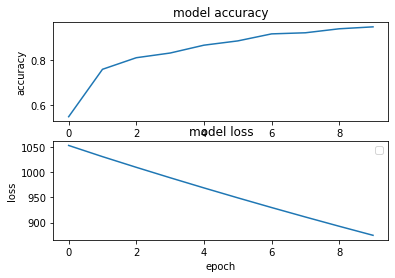

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')


plt.subplot(2, 1, 2)
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.tight_layout()

## Discussion
The model is built from `keras.tuner`, which is to let the mechine ran all the data choices for me.     
    
At first when I set up with my model, I had all the accuracy score as only 0.07 or 0.10. After then I tried to set more layers than people usually did and tried with more neruals as well. I found out that the accurary score is going up a little bit, but not too much.     
     
I then started to use some regularization of L1/L2 and some dropouts and I found L2 makes my performance better. However, though it seems to be better, the accuracy score is still 0.20+.     
     
Finally, I started to add up the epoch number, which makes the running time to be super big, and by training my dataset for several trials and epochs, I got my final accuracy to be 0.55. I think this might be a good accuracy score because the `Dense` layer is used to train the models that are not pictures. The `Dense` layeys are usually made to train these supervised data. If I have to raise my accuracy score to about 80 or 90, I probably should add some `max pooling1` layer into my tuner. 